# OSM COMPETITION: A predictive model for PfATP4 activity.

The aim of the competition is to develop a computational model that predicts which molecules will block the malaria parasite's ion pump, PfATP4.

Submitted by James McCulloch - james.duncan.mcculloch@gmail.com

## Preliminary Results

### The test set predictive AUC score was 0.77;  [Active, Partial, Inactive]

Different models had a range of AUC in [0.75, 0.82] depending on the NN technique used, however overfitting is suspected for the 0.82 figure.

#### Most of the predictive information is coming from the Dragon QSAR statistics (or equivalently, the RDKIT fingerprints encode a subset of the same information)

#### Increasing the predictive score can be achieved by modelling the interaction of intra-molecular components (Greg Landrum's similarity maps).
 


Data Preliminaries.

The dataset was prepared from the supplied spreadsheet “ION Regulation Data for OSM Competition.xls”. No additional compounds (e.g. from the Master Spreadsheet) were used.

Records were to be separated into “TRAIN” or “TEST” records for classification. All records with an “Ion Regulation Test Set” column of “B” or “C” were tagged as “TEST”.

# 1. ION_ACTIVITY Analysis

Data for ION_ACTIVITY analysis.

The ION_ACTIVITY field was generated from the “Ion Regulation Activity” spreadsheet column and was treated as a classification field with “ACTIVE” = 1, “PARTIAL” = 0.5 (only a few of these) and “INACTIVE” = 0.

From a total of 703 valid records in the competition spreadsheet (SMILES available) there were 438 "TRAIN" records and 35 "TEST" records with a valid ION_ACTIVITY.

ION_ACTIVITY analysis methodology.

A number of Machine Learning classifiers (tabulated below ) were trained against various molecular descriptors (tabulated below) of the "TRAIN" records then the 35 "TEST" records were presented to the trained ML classifiers. The results of the ability of the ML classifier to determine the ION_ACTIVITY status of "TEST" molecules are tabulated below as a micro Area Under Curve (AUC) statistic (since this is a 3 class classification problem).

In [1]:
from IPython.display import display
import pandas as pd
ion_results = pd.read_csv("./ion_results.csv")
display(ion_results)

,MODEL,MCCFP,M2048_2,M2048_4,TOP2048,DRAGON
0,DTC,0.53,0.55,0.66,0.53,0.66
1,LOGC,0.69,0.63,0.63,0.66,0.70
2,KNNC,0.67,0.69,0.67,0.78,0.69
3,SVMC,0.65,0.66,0.65,0.65,0.67
4,NBC,0.72,0.65,0.70,0.61,0.62
5,DNN,0.65,0.57,0.60,0.71,0.81


Where the ML MODELs are as follows:

1. DTC - A Decision Tree model from SKLearn.
2. LOGC - A Logistic classifier from SKLearn.
3. KNNC - K Nearest Neighbours classifier from SKLearn.
4. SVMC - A Support Vector Machine classifier from SKLearn.
5. NBC - A Naive Bayes classifier from SKLearn.
6. DNN - A Deep Neural Network classifier [2048, 2048, 512, 64, 3] from the Keras toolkit. Cross-entropy loss function.

The molecular descriptors are as folows:

1. MCCFP - The MACCS molecular fingerprint from RDKIT
2. M2048 - A 2048 bit, mol radius = 2 (mol radius = 1 for NNs), Morgan fingerprint from RDKIT
3. M2048_4 - A 2048 bit, mol radius = 4 (mol radius = 5 for NNs), Morgan fingerprint from RDKIT
4. TOP2048 - A 2048 bit Topological fingerprint from RDKIT
5. DRAGON - A vector of 1666 pharmacophore molecular fields scaled to be on the interval [0, 1].

Modelling.

To run these models, download (follow the readme setup) the software on gitHub here: https://github.com/kellerberrin/OSM-QSAR

For the SKLearn models (--help for flag decriptions) the following cmd was used:

$python OSM_QSAR.py --classify [model] --depend ION_ACTIVITY --indep [descriptor]

For the DNN with MORGAN and TOPOLOGICAL descriptors:

$python OSM_QSAR.py --classify ion_m --depend ION_ACTIVITY --indep [descriptor] --train 500 --check 20

For the Keras DNN with the DRAGON descriptor:

$python OSM_QSAR.py --classify ion_d --depend ION_ACTIVITY --indep DRAGON --train 50000 --check 1000

For the Tensorflow DNN with the DRAGON descriptor:

$python OSM_QSAR.py --classify dnnmv --depend ION_ACTIVITY --train 1000 --check 20

For the DNN with the MACCS descriptor:

$python OSM_QSAR.py --classify ion_macc --depend ION_ACTIVITY --indep MACCFP --train 500 --check 20


Note that training the DNN on the DRAGON descriptor was slow because the learning rate optimization parameters were  reduced to ensure convergence. The DNN converges after about 10000 to 20000 training epochs. Covergence is not linear and the best technique is to leave the DNN train overnight (no GPU!) and choose the the optimal model by reviewing the model/data statistics logs. Watch for overfitting.

The problem with training on DRAGON is dimensionality, we have 438 training records and DRAGON has 1666 fields. Note that while it is true that the fingerprints have a notional dimensionality of 2048, most of the vector is empty and 'effective' dimension is much lower. 

Practical tips.

As powerful as they are, overfitting is a serious problem with DNNs. This means they will fit the training set perfectly and, since the test set is related to the training set, do fairly well the test set. But they will classify comparatively poorly on random novel molecules. The conventional way adjust for this is cross validation where we stratify the test set into different 'folds' (SKLearn StratifiedKFold is a good choice) and simultaneously train several different models and compare them after training. However, with only 438 training molecules we simply do not have that luxury when devloping a predictive ION_ACTIVITY model.


When training there 3 statistics you should keep an eye on (these are automatically recorded with much else in the statistics files).
1. The micro AUC, this tells us how the DNN performs on the test molecules (important) but does not say if the result was achieved through overfitting.
2. The value of the objective function for each epoch.
3. The value of the loss function - cross entropy was used in all NN models.

Results Discussion.

The summary model and micro AUC values recorded are interesting and very encouraging. When we examine the classification results in detail, there are some important and robust conclusions. 

We examine the detailed classification results from the Naive Bayes classifier (nbc) using the Morgan (radius 4) fingerprint and compare this to the DNN (Tensorflow) results using the DRAGON descriptors. 

1. The DNN trained on the DRAGON descriptors gives a micro AUC of 0.81 on the test molecules. However this model may be overfitted (although I have been careful about this) - a serious problem with DNNs. Update - I now have a model (the direct TensorFlow API, not Keras) that quickly and reliably trains on DRAGON but the AUC is lower at 0.75 and 0.77.

2. We compare molecules with similar molecular structures and similar classifier activity ranking but different PfATP4 activity using similarity maps. This shows that we can further develop PfATP4 activity classifiers by looking at the interaction between intra-molecular components rather than just molecular structure. 

3. The RDKIT fingerprints, MORGAN,  MACCS and TOPOLOGICAL, when trained against a DNN, perform modestly with micro AUC in the range 0.57 - 0.71.

4. The SKLearn classifiers performed surprisingly well (they were only added to provide a baseline for the DNNs), and on the fingerprint descriptors, exceed the performance of the DNNs. This is a counter-intuitive result and needs to be investigated further.

5. We created a DNN (the net of nets) that takes as it's input the classification probabilities of all the individual descriptor NN models above and produces an optimal composite classification probability - a meta model. This model gives our highest AUC score 0.82. Although it should be noted that the DRAGON classifier (Keras) gives a score of 0.81. We discuss the "net of nets" in greater detail below and find that it is an excellent candidate for an arbitrary discriminant function.  

6. We created another novel NN which attempted to train all the description vectors concatenated together (the kitchen sink). This NN used a different software toolbox (the direct TensorFlow API, not Keras) and was much faster and converged more quickly (less epochs) than the Keras NNs even though it notionally had the same specs (architecture, optimizer and loss function). Predictably, the kitchen sink did not generalize well and produced AUCs in the mid 0.6s. But then training on just DRAGON also produced an AUC of 0.75 (540 epochs) to 0.77 (840 epochs) providing circumstantial evidence that the RDKIT fingerprints do not have ION_ACTIVITY information that is not already encrypted in DRAGON.   


We now take a closer look at the results. The small training set means that we cannot use cross-validation for model validation. Overfitting is a major problem for NNs and since the model explanatory power comes from training on the DRAGON molecular descriptors, it is the quality of classifier fit to DRAGON that is interesting.   

We examine DRAGON using 4 classifiers.

1. LOGC_ACTIVE is the [ACTIVE] molecular probability map produced training a logistic classifier from SKLearn.
2. D_ACTIVE was the [ACTIVE] molecular probability map obtained by training a NN [2048, 2048, 512, 64, 3] using the Keras toolkit. This model produced the highest AUC = 0.81, but convergence was very slow (12000 epochs) and erratic.
3. D540_ACTIVE was the [ACTIVE] molecular probability map obtained by training a NN [2048, 2048, 512, 64, 3] using the Tensorflow toolkit directly. This NN used the same optimizer and objective function as the Keras NN (Keras is just a 'front-end' to Tensorflow) and coverged in 540 epochs, AUC = 0.75.
3. D840_ACTIVE was the [ACTIVE] molecular probability map the resulted by training D540_ACTIVE for another 300 epochs, AUC = 0.77.

Firstly, we examine the Spearman rank correlations of the [ACTIVE] probability maps. 

In [2]:
# Import the probability maps
import pandas as pd
test_results = pd.read_csv("./test_results.csv")
train_results = pd.read_csv("./train_results.csv")
dragon_active = ["LOGC_ACTIVE", "D_ACTIVE", "D540_ACTIVE", "D840_ACTIVE"]
fingerprint_active = ["M1_ACTIVE", "M5_ACTIVE", "TOP_ACTIVE", "MACC_ACTIVE"]
all_active = dragon_active + fingerprint_active + ["META_ACTIVE"]

In [3]:
# Train results Spearman correlation
corr = train_results[dragon_active].corr(method="spearman")
corr

,LOGC_ACTIVE,D_ACTIVE,D540_ACTIVE,D840_ACTIVE
LOGC_ACTIVE,1.000000,0.689568,0.871341,0.870450
D_ACTIVE,0.689568,1.000000,0.739406,0.697132
D540_ACTIVE,0.871341,0.739406,1.000000,0.981495
D840_ACTIVE,0.870450,0.697132,0.981495,1.000000


In [4]:
# Test results Spearman correlation
corr = test_results[dragon_active].corr(method="spearman")
corr

,LOGC_ACTIVE,D_ACTIVE,D540_ACTIVE,D840_ACTIVE
LOGC_ACTIVE,1.000000,0.410644,0.875630,0.828571
D_ACTIVE,0.410644,1.000000,0.419888,0.427451
D540_ACTIVE,0.875630,0.419888,1.000000,0.830812
D840_ACTIVE,0.828571,0.427451,0.830812,1.000000


Commentary.

The correlations of the probability maps are positive with slightly lower correlations from the test set compared to the training set. This was expected. The most important feature is that the correlation of D_ACTIVE (the Keras NN) with the other 3 models is significantly lower. This is a problem and strongly suggests that D_ACTIVE may be overfitted.

We visualize the training set probability maps by normalizing them to the unit interval [0, 1] and sorting them in descending order. 

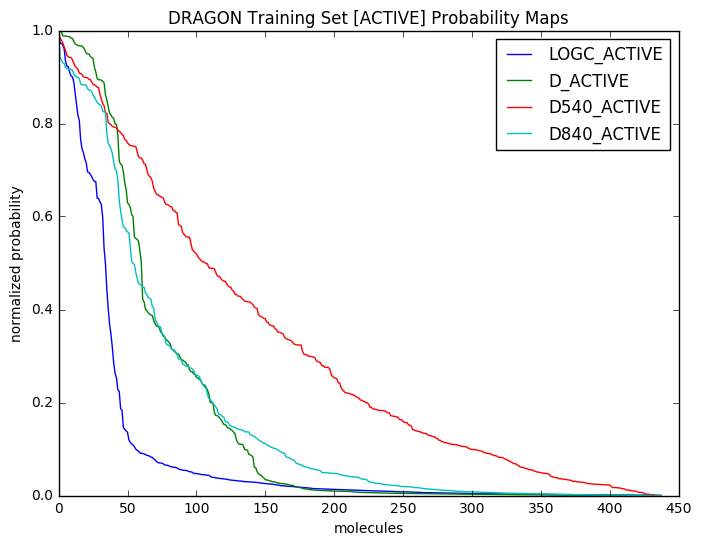

In [5]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from pylab import *
from sklearn.preprocessing import minmax_scale

def sort_map(column):
    array = minmax_scale(train_results[column])
    return array[np.argsort(-array)]

scale = 1.0
fig = plt.figure(num=None, figsize=(8 * scale, 6 * scale), dpi=80, facecolor='w', edgecolor='k')
for map in dragon_active: plt.plot(sort_map(map), label=map)
xlabel("molecules")
ylabel("normalized probability")
title("DRAGON Training Set [ACTIVE] Probability Maps")
legend(loc=1); # upper right corner

Commentary.

The probability maps show the probability (normalized to [1,0]) that an individual molecule is [ACTIVE] sorted from highest to lowest. The D540_ACTIVE model shows a linear(ish) decline. The D_ACTIVE and D840_ACTIVE models are similar and show that only 150 molecules have a postive probability of being [ACTIVE] these models have the highest AUC [0.81, 0.77]. The LOGC_ACTIVE non-NN SKLearn logistic classifier suggests that only about 50 molecules have a positive probability of being [ACTIVE].

The true probability map is unknown (this is what we are trying to discover) but all the maps depicted look non-pathological and credible. The D540_ACTIVE map evolves to the D840_ACTIVE map (these are training epochs from the same training run) so it is reasonable to assume that the functional form of the "true" map lies between and includes these maps.   

The next graph visualizes the D840_PARTIAL model that assigns probabilities that a molecule will have [PARTIAL] activity againt PfATP4.

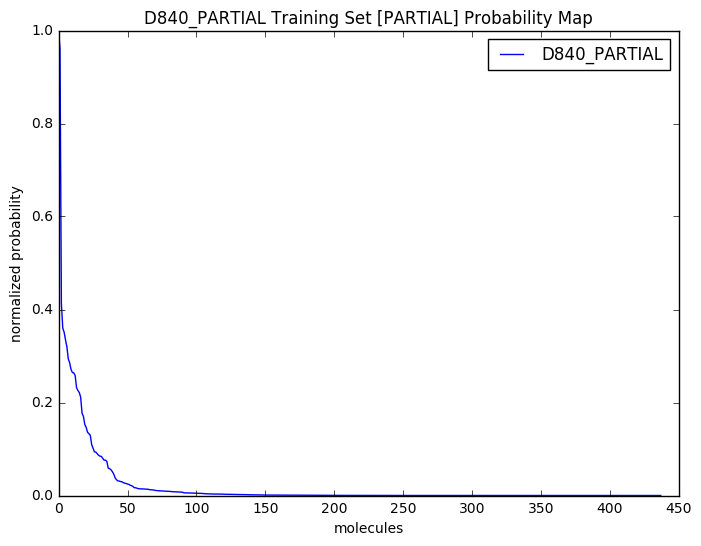

In [6]:
scale = 1.0
fig = plt.figure(num=None, figsize=(8 * scale, 6 * scale), dpi=80, facecolor='w', edgecolor='k')
plt.plot(sort_map("D840_PARTIAL"), label="D840_PARTIAL")
xlabel("molecules")
ylabel("normalized probability")
title("D840_PARTIAL Training Set [PARTIAL] Probability Map")
legend(loc=1); # upper right corner

Commentary. This is exactly what we expect to see, there is only one molecule (1/438) that is [PARTIAL] against PfATP4 in the training set and we expect the resultant probability map to be highly selective. And it is.

Next we graph the fingerprint [ACTIVE] probability maps. For comparison the META_ACTIVE (the net of nets) and D840_ACTIVE maps are also shown. 

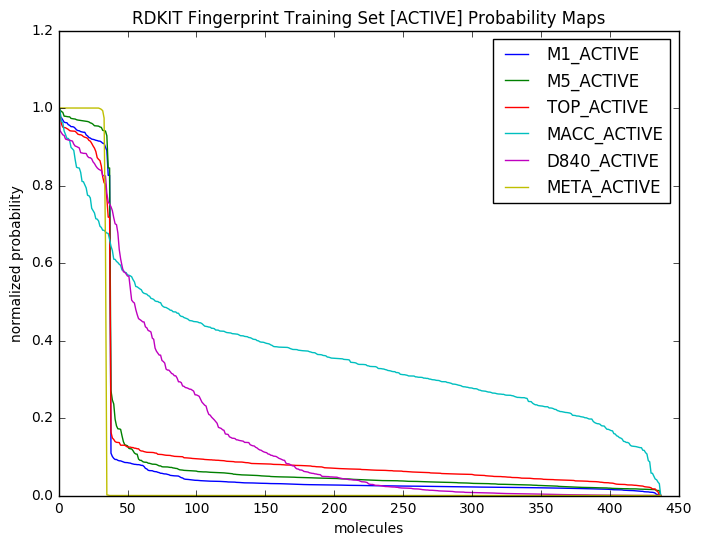

In [7]:
scale = 1
fig = plt.figure(num=None, figsize=(8 * scale, 6 * scale), dpi=80, facecolor='w', edgecolor='k')
finger_maps = fingerprint_active + ["D840_ACTIVE", "META_ACTIVE"]
for map in finger_maps: plt.plot(sort_map(map), label=map)
xlabel("molecules")
ylabel("normalized probability")
title("RDKIT Fingerprint Training Set [ACTIVE] Probability Maps")
legend(loc=1); # upper right corner

The RDKIT fingerprint classifiers are (see the RDKIT documentation for further information).

1. M1_ACTIVE is the [ACTIVE] molecular probability map produced by training against a Morgan fingerprint of molecular radius 1.
2. M5_ACTIVE is the [ACTIVE] molecular probability map produced by training against a Morgan fingerprint of molecular radius 5.
3. TOP_ACTIVE is the [ACTIVE] molecular probability map produced by training against a Topological fingerprint.
4. MACC_ACTIVE is the [ACTIVE] molecular probability map produced by training against a MACCS fingerprint.

Commentary.

The M1_ACTIVE, M5_ACTIVE and TOP_ACTIVE classifiers fall off a cliff after about 30 molecules, this suggests they are highly sensitive to a particular molecular structure within the training dataset and this limits their utility.

The MACC_ACTIVE map however has an interesting and unique functional form that suggests it may have an information content that can be used to complement the DRAGON based classifiers.

The most interesting probability map is META_ACTIVE. To recap, this NN uses as it's input the probability maps of other classifiers (the net of nets). It acts as a discriminant function and optimally re-maps probability maps onto a classification step function. In the graph above, the loss function was cross entropy, the same loss function used in other NNs. However, the loss function can be anything we deem useful, such as whole cell EC50 potency. Potentially very useful. 


## D840_ACTIVE Molecular Classification.

The section examines test molecules that are classified by D840_ACTIVE. The python code comes from Greg Landrum's blog posts.
You must be in an anaconda (or other) python environment that has previously setup rdkit to execute this code.

In [8]:
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
from rdkit import rdBase
IPythonConsole.ipython_useSVG=True

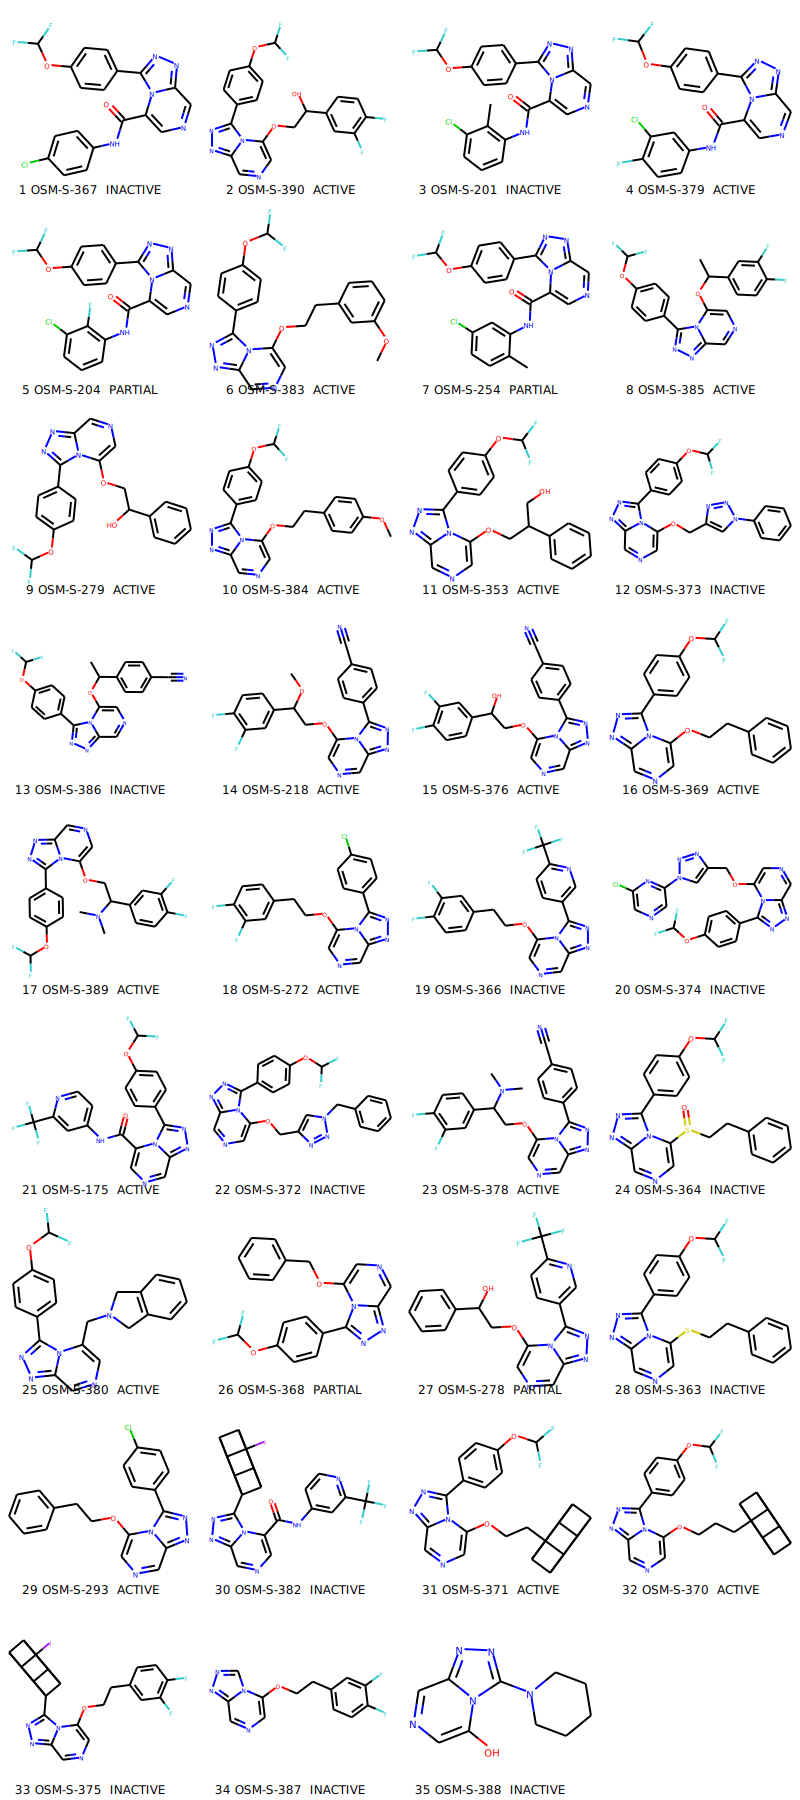

In [9]:
sorted = test_results.sort_values("D840_ACTIVE", ascending=False)
smiles = sorted["SMILE"].tolist()
mols = [Chem.MolFromSmiles(smile) for smile in smiles]
id = sorted["ID"].tolist()
klass =  sorted["ACTUAL"].tolist()
labels = []
for idx in range(len(id)):
    labels.append("{} {} {}".format(idx+1, id[idx], klass[idx]))
Draw.MolsToGridImage(mols,legends=labels,molsPerRow=4)

### Commentary

This classification result demonstrates the strength and, importantly, the weakness of using the DRAGON molecular descriptors to classify PfATP4 Activity. But this "weakness" could be a significant insight.

The D840_ACTIVE classifier examines the DRAGON molecular descriptions of the test set and assigns a high probability of [ACTIVE] to any molecule with similar structural characteristics to [ACTIVE] molecules in the training set. We can see that the top 13 ranked molecules all have exactly the same structure on the Triazole arm of the molecule. So the classifier is doing it's job.

The "weakness" comes when we examine the molecules OSM-S-367, OSM-S-201, OSM-S-379 and OSM-204. These are classified in the top 5 molecules likely to be [ACTIVE]. However OSM-S-367 and OSM-S-201 are [INACTIVE] and OSM-S-204 is [PARTIAL].

If we examine the Pyridine arm of these molecules, these are all similar to the structure of the [ACTIVE] OSM-S-379.

Greg Landrum had the very interesting idea of using the probability map of a molecular classifier to examine which components of the molecule increased or decreased the molecules position on the probability map. In other words, in our case, which parts of the molecule increase or decrease the likelihood of the molecule being [ACTIVE] against PfATP4. These are called similarity maps. Of crucial importance is that these similarity maps also capture the interaction between molecular components.

He has similarity map software in rdkit that works with rdkit fingerprint molecular descriptors. This software was bolted onto the Morgan fingerprint D1_ACTIVE classifier and the results are displayed below. 

The similarity maps below all suggest that the difference in PfATP4 activity between OSM-S-379 and the other 3 molecules is due to the interaction of the probability map sensitivity of the peripheral atoms on the benzene aromatic on the Pyridine arm with the benzene aromatic on the Triazole arm of the molecules. The interaction with the benzene aromatic on the Triazole arm appears to be lower for both OSM-S-379 and OSM-S-204.

We are not asserting that this interaction is the cause of the molecular activity differences and we discussed the shortcomings of the Morgan fingerprint classifier above. However the concept shows, in general, how we can further develop PfATP4 activity classifiers; by looking at the interaction between molecular components. Greg Landrum's similarity maps, because the concept and software is already developed, looks like a good place to start. The next step is to extend similariy maps to the more robust DRAGON classifiers.

Lastly, we can also gain insights by looking at molecules that are [ACTIVE] but ranked comparatively lowly by the D840_ACTIVE classifier. Molecules OSM-S-371 and OSM-S-370 are [ACTIVE] but are classified as 31/35 and 32/35 respectively because the  structure of the Pyridine arm of these molecules is quite different to that of highly ranked molecules. When we generate the similarity maps (see below) for these molecules we see that it is, once again, the interaction of the Pyridine arm of these molecules (or lack of it, in this case) with the benzene aromatic on the Triazole arm that appears to be important.

The OSM_QSAR.py software automatically generates test molecule similarity maps when training a NN on Morgan fingerprints. This is suppressed when performing a checkpointed (the --check flag) training session (generating the maps is CPU intensive and would be overwritten by the next checkpoint anyway). You can generate similarity maps for training molecules by using the --extend flag.  


Molecule OSM-S-367 is [INACTIVE] and is ranked 1/35 likely to be [ACTIVE]. It is structurally close to OSM-S-379 which is [ACTIVE] and ranked 4/35.

Similarity maps are based on the class membership probability map that a classifier (trained NN) uses to determine if a molecule is [ACTIVE, PARTIAL, INACTIVE].  Molecular structure and structural interaction that makes the molecule less probable to be [ACTIVE] is blue, more probable to be [ACTIVE] is red. For further information on similarity maps read Greg Landrum's blog and paper.

![OSM_S_367](OSM-S-367_r1.png)

Molecule OSM-S-379 [ACTIVE] and is ranked 4/35

![OSM_S_379](OSM-S-379_r1.png)

Molecule OSM-S-201 is [INACTIVE] and is ranked 3/35

![OSM_S_201](OSM-S-201_r1.png)

Molecule OSM-S-204 is [PARTIAL] and is ranked 5/35

![OSM_S_204](OSM-S-204_r1.png)

Molecule OSM-S-371 is [ACTIVE] and is ranked 31/35

![OSM_S_371](OSM-S-371_r1.png)

Molecule OSM-S-370 is [ACTIVE] and is ranked 32/35

![OSM_S_370](OSM-S-370_r1.png)